# **Introduction**

Welcome to Dagi's and Amir's Project Colab!

We aim to explore and build a model for the Toxic Tweets dataset. We found that generally the majority of tweets were not objectively toxic, and so our job was primarily to fine-tune and really look for those 'triggers' that make a tweet universally toxic.

One **important note** to make is that the Kaggle problem tried to deal with this dataset with a more cross language focus (tracking the stats of toxicity accross different language tweets around the world) while we are more focused on classifiying comments as toxic (different scales of toxicity). This has lead us **to split the given data** into train, validation, and test because the test.csv's Kaggle had were completely irrelevant to our study.

**PLEASE NOTE THE FOLLOWING:**
* Make sure to check that T4 is the chosen GPU! This colab requires a runtime type of T4 or greater (RAM). Every free account gets T4 privilliges for a certain limit a time but **you need to set this runtime** even if you don't have pro. You can also use burner Google accounts if you want to run this multiple times consecutively 👍.
* We HIGHLY recommend pressing run all and giving everything ~ 40 minutes to run, ths is mainly due to the complexity of the final model!
* Please be VERY conservative with re-runs, only run a cell once unless otherwise told, because RAM is very limited and we barely had enough to run everything.
* We sincerely appreciate your patience and cooperation
* If you re-run in the same session just restart (always run everything in one new session)

We aim to build an accurate model to classify a comment as toxic or not, and a stretch goal of classifiying a comment into one of the many classes/severities of toxicity depending feedback recieved on our milestones.

**If you just can't figure out how to run this, or just want to compare you run** please find a completed run pdf <a href='https://drive.google.com/file/d/1k8oNV2ZW4boOkGeZdrvXoZzHMJGM7bWY/view?usp=sharing'>here</a>.

# **Setting Up**


In [ ]:
# @title Import Libraries
!pip install -qqq wordcloud > /dev/null
!pip install -qqq gradio jinja2 > /dev/null
!pip install -qqq gradio --upgrade > /dev/null
from PIL import Image
import requests
import numpy as np
import re
from wordcloud import WordCloud
import plotly.express as px
import pandas as pd
from wordcloud import STOPWORDS
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
import gradio as gr
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
import time

sns.set(style='darkgrid')

##**Importing Data**
We found a way to import the csv without having to mount the drive, which requires you having the right csv in the right folder in your own Google Drive. Now we've used gdown to locally store the csv from our public Drive link.

In [ ]:
import gdown

# Download the CSV file from Google Drive
file_id = '1MP_Ojnq8Zt8fgB9biHRzA9ol_n2frrDS'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'jigsaw-toxic-comment-train.csv'
gdown.download(url, output, quiet=False)

# Read the CSV file into a DataFrame
data_info = pd.read_csv(output)

#For stretch goal
original_data = data_info

Downloading...
From: https://drive.google.com/uc?id=1MP_Ojnq8Zt8fgB9biHRzA9ol_n2frrDS
To: /content/jigsaw-toxic-comment-train.csv
100%|██████████| 95.5M/95.5M [00:00<00:00, 123MB/s]


## **Data Preprocessing**

In [ ]:
# Pre-process the text data
# For simplicity, let's start with tokenization and removing punctuation.
data_info['comment_text'] = data_info['comment_text'].str.lower()  # Convert text to lowercase
data_info['comment_text'] = data_info['comment_text'].str.replace(r'\W', ' ')  # Remove punctuation
data_info['comment_text'] = data_info['comment_text'].str.replace(r'\n', ' ')  # Remove new line char

#Let's clean things up further by removing links and usernames
def clean(text):
    text = text.fillna("fillna").str.lower()
    text = text.map(lambda x: re.sub('\\n',' ',str(x)))
    text = text.map(lambda x: re.sub("\[\[User.*",'',str(x)))
    text = text.map(lambda x: re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",'',str(x)))
    text = text.map(lambda x: re.sub("\(http://.*?\s\(http://.*\)",'',str(x)))
    return text

data_info["comment_text"] = clean(data_info["comment_text"])

#randomize
data_info = data_info.sample(frac=1, random_state=42).reset_index(drop=True)

We would also greatly benefit by adding in a column that marks those tweets that are not toxic at all.

In [ ]:
# Define the toxicity labels
toxicity_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Add a new column 'not_toxic' indicating whether a comment is toxic or not
data_info['negative_comment'] = (data_info[toxicity_labels].max(axis=1) == 1).astype(int)
data_info.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,negative_comment
0,2ada3066c863097d,:you might like to consider that i don't give ...,1,0,1,0,1,0,1
1,f685d54247b735a8,"what the heck are you talking about? i ask, my...",0,0,0,0,0,0,0
2,22ed5297921900fb,uncle tom house niggers,1,0,1,0,0,1,1
3,a364a9ef7c480da8,"well, just because you hate the word doesn't m...",0,0,0,0,0,0,0
4,09884c47e5720176,source: places named scotland,0,0,0,0,0,0,0


## **Tokenizing**

Let's tokenize our words. Also, we noticed that the lengths are varrying by quite a range, so let's compress and pad the tweets to a length of 150.

This also allows us to truncate the tweets and thus allow for a more limited number of possible token positions. We also wanted to try our hand at coding out the tokenization function ourselves instead of using the API.

In [ ]:
#Global token mapping
token_mapping = {}

def tokenize(texts):
    """Function to tokenize a sequence of input string"""

    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(texts)

    # Create a token mapping
    token_mapping = tokenizer.word_index

    # Tokenize the texts
    tokenized_texts = tokenizer.texts_to_sequences(texts)
    return token_mapping, tokenized_texts

# Tokenize the data
token_mapping, tokenized_comments = tokenize(data_info['comment_text'])

In [ ]:
def decode(token_ids):
    """Return a string with the decoded text given a list of token ids."""

    # we can reverse the mapping so that lookup time is cut down here.
    reverse_token_mapping = {v: k for k, v in token_mapping.items()}
    tokens = [reverse_token_mapping.get(i, '#') for i in token_ids]

    # Connect the string tokens with a space.
    return ' '.join(tokens)

# Show the ids corresponding to tokens in the first example.
print(tokenized_comments[1])
print(decode(tokenized_comments[1]))

[38, 1, 3759, 18, 6, 602, 35, 7, 214, 30, 97, 21092, 69, 20, 210, 8, 2188, 4, 22, 72, 2188, 70, 39, 11, 997, 16, 2661]
what the heck are you talking about i ask my good chum because your question is unclear and if it's unclear how can it possibly be answered


We add a new column to the data set to store the tokenized version of each comment within the entire dataframe. This ensures that when we split the data, the mappings for each token to word is consistent among entire data set. Before, we were running into a problem where in the test data for instance "hello" mapped to 43 but in the train data "hello" mapped to 19.

In [ ]:
data_info['tokenize_text'] = tokenized_comments

## **Splitting the Data**

Here is where we needed to play around with the Kaggle CSV to suit our study. More like 64% for training, 16% for validation, and 20% for testing.

In [ ]:
total_samples = len(data_info)
train_size = int(0.64 * total_samples)
val_size = int(0.16 * total_samples)

# Splitting the data into train, validation, and test sets
train_data = data_info[:train_size]
val_data = data_info[train_size:train_size+val_size]
test_data = data_info[train_size+val_size:]

X_train = train_data['tokenize_text']
Y_train = train_data['negative_comment']

X_val = val_data['tokenize_text']
Y_val = val_data['negative_comment']

X_test = test_data['tokenize_text']
Y_test = test_data['negative_comment']

print("Training dataset size:", len(train_data))
print("Validation dataset size:", len(val_data))
print("Test dataset size:", len(test_data))

Training dataset size: 143071
Validation dataset size: 35767
Test dataset size: 44711


Let's also categorize the data for our stretch goal of multiclassification (levels of toxicity) model 3.

In [ ]:
X_stretch = original_data['comment_text']
Y_stretch = original_data[original_data.columns[2:]].values

## **Padding the Data**

In [ ]:
def padding_data(seq, maximum_len):
    return np.array(list(
      tf.keras.preprocessing.sequence.pad_sequences(
          seq, maximum_len, padding='post', value=0)))

# Pad and truncate to 150 tokens.
X_train_padded = padding_data(X_train, maximum_len=200)
X_val_padded = padding_data(X_val, maximum_len=200)

In [ ]:
def plot_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

# **Data Analysis**

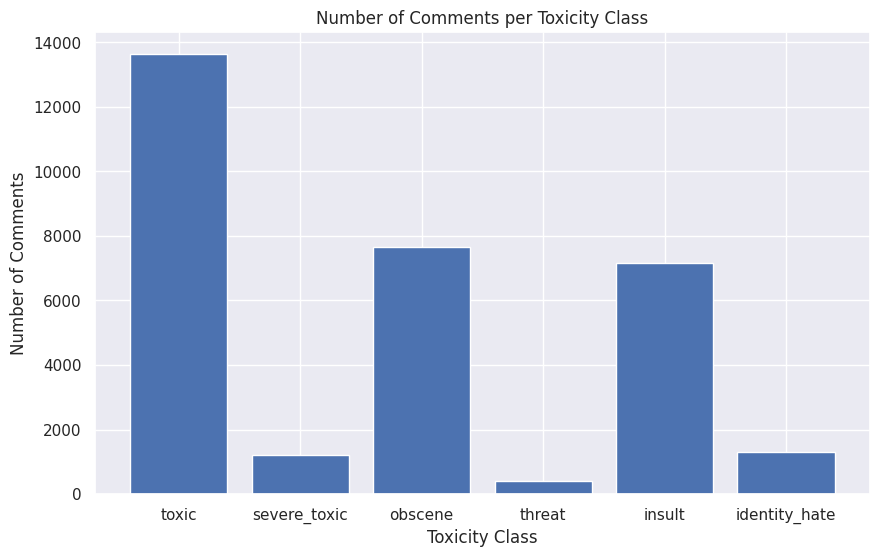

In [ ]:
# @title No. of Comments Per Toxicity Class
# Determining how many categories land in each class
toxicity_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Count the number of comments for each class
class_counts = {}
for label in toxicity_labels:
    class_counts[label] = train_data[label].sum()

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Number of Comments per Toxicity Class')
plt.xlabel('Toxicity Class')
plt.ylabel('Number of Comments')
plt.show()

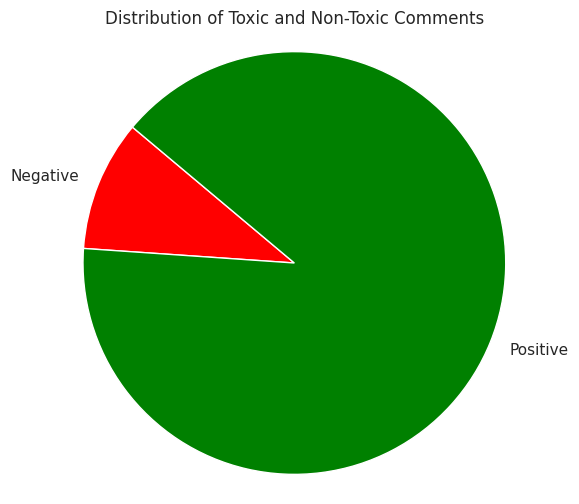

In [ ]:
# @title Toxic vs Non- Toxic Comments
# Count the number of toxic and non-toxic comments
negative_comments_count = train_data[train_data['negative_comment'] == 1].shape[0]
positive_comments_count = train_data[train_data['negative_comment'] == 0].shape[0]

# Create labels and sizes for the pie chart
labels = ['Negative', 'Positive']
sizes = [negative_comments_count, positive_comments_count]
colors = ['red', 'green']

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, startangle=140)
plt.title('Distribution of Toxic and Non-Toxic Comments')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie chart
plt.show()

Clearly we can tell that the majority of tweets are toxic. This immediatly lead us to an idea for how to build a baseline. But before getting into that, let's also examine the different categories/toxic levels some more.

**Please note**, if the following celll throws a loc error, simply run it again, the dataframes can sometimes act up inbetween splits.

In [ ]:
# @title Avg Len of Comment per Class
toxicity_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'negative_comment']
train_data.loc[:, 'comment_length'] = train_data['comment_text'].apply(len)

# Calculate the average length of comments for each toxicity label
average_lengths = {}
for label in toxicity_labels:
    average_lengths[label] = train_data[train_data[label] == 1]['comment_length'].mean()

# Print the results
for label, avg_length in average_lengths.items():
    print(f"Average length of comments labeled as {label}: {avg_length}")

Average length of comments labeled as toxic: 280.83675564681727
Average length of comments labeled as severe_toxic: 508.84249384741594
Average length of comments labeled as obscene: 286.38623027774156
Average length of comments labeled as threat: 313.6256038647343
Average length of comments labeled as insult: 276.68960223307744
Average length of comments labeled as identity_hate: 322.14307692307693
Average length of comments labeled as negative_comment: 287.92196007259525


<ipython-input-19-8cf6e2564130>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'comment_length'] = train_data['comment_text'].apply(len)


Let's also build maps for words that are often attributed to each toxicity scale

In [ ]:
# @title Maps for words that are often attributed to each toxicity scale
def nonan(x):
    if type(x) == str:
        return x.replace("\n", "")
    else:
        return ""
print("Your patience is appreciated (˶ᵔ ᵕ ᵔ˶)")
text = ' '.join([nonan(abstract) for abstract in train_data["comment_text"]])
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(text)
fig = px.imshow(wordcloud)
fig.update_layout(title_text='Common words found in comments')

Your patience is appreciated (˶ᵔ ᵕ ᵔ˶)


Now let's investigate the toxic words map, **viewer discretion is advised**!

Be warned this is abrasive language (っ◞‸◟ c)


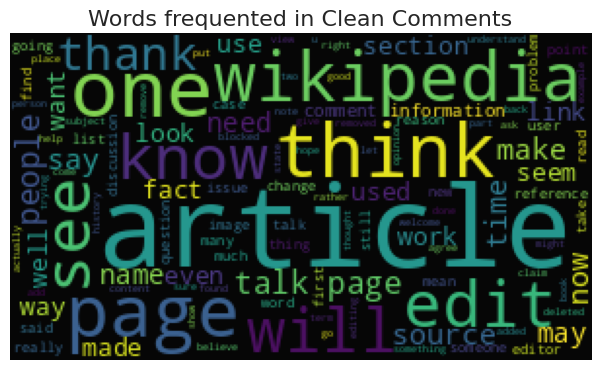

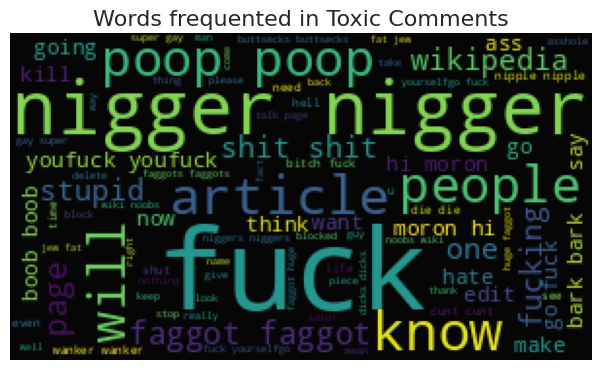

In [ ]:
# @title Frequent Words in Toxic vs Non-Toxic Comments
# Using a mask to
print("Be warned this is abrasive language (っ◞‸◟ c)")
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRp0XL98mkHQPtzD9Q-zt5RLGiHLD2TJEtsSQ0Sz0_yKQ&s"
response = requests.get(url)
with open("clean_mask.png", "wb") as f:
    f.write(response.content)
stopword = set(STOPWORDS)

# Open the image
clean_mask = np.array(Image.open("clean_mask.png"))

# Use the opened image in your code
subset = train_data.query("toxic == 0")
text = subset.comment_text.values
wc = WordCloud(background_color="black",max_words=2000,mask=clean_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(7.5, 7.5))
plt.axis("off")
plt.title("Words frequented in Clean Comments", fontsize=16)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

subset = train_data.query("toxic == 1")
text = subset.comment_text.values
wc = WordCloud(background_color="black",max_words=2000,mask=clean_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(7.5, 7.5))
plt.axis("off")
plt.title("Words frequented in Toxic Comments", fontsize=16)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

While it hurts to read, we need to also examine the words used for the varying levels of toxicity.

All we can do is aplogize but we do need to examine these for the sake of accuracy
⡴⠒⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣼⠉⠳⡆⠀
⣇⠰⠉⢙⡄⠀⠀⣴⠖⢦⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⣆⠁⠙⡆
⠘⡇⢠⠞⠉⠙⣾⠃⢀⡼⠀⠀⠀⠀⠀⠀⠀⢀⣼⡀⠄⢷⣄⣀⠀⠀⠀⠀⠀⠀⠀⠰⠒⠲⡄⠀⣏⣆⣀⡍
⠀⢠⡏⠀⡤⠒⠃⠀⡜⠀⠀⠀⠀⠀⢀⣴⠾⠛⡁⠀⠀⢀⣈⡉⠙⠳⣤⡀⠀⠀⠀⠘⣆⠀⣇⡼⢋⠀⠀⢱
⠀⠘⣇⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⡴⢋⡣⠊⡩⠋⠀⠀⠀⠣⡉⠲⣄⠀⠙⢆⠀⠀⠀⣸⠀⢉⠀⢀⠿⠀⢸
⠀⠀⠸⡄⠀⠈⢳⣄⡇⠀⠀⢀⡞⠀⠈⠀⢀⣴⣾⣿⣿⣿⣿⣦⡀⠀⠀⠀⠈⢧⠀⠀⢳⣰⠁⠀⠀⠀⣠⠃
⠀⠀⠀⠘⢄⣀⣸⠃⠀⠀⠀⡸⠀⠀⠀⢠⣿⣿⣿⣿⣿⣿⣿⣿⣿⣆⠀⠀⠀⠈⣇⠀⠀⠙⢄⣀⠤⠚⠁⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⢠⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡄⠀⠀⠀⢹⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡀⠀⠀⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡀⠀⠀⢘⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⢰⣿⣿⣿⡿⠛⠁⠀⠉⠛⢿⣿⣿⣿⣧⠀⠀⣼⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⡀⣸⣿⣿⠟⠀⠀⠀⠀⠀⠀⠀⢻⣿⣿⣿⡀⢀⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⡇⠹⠿⠋⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⡿⠁⡏⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠻⣤⣞⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢢⣀⣠⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠲⢤⣀⣀⠀⢀⣀⣀⠤⠒⠉⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
This is Frank, Frank does not appreciate how nasty people are online!


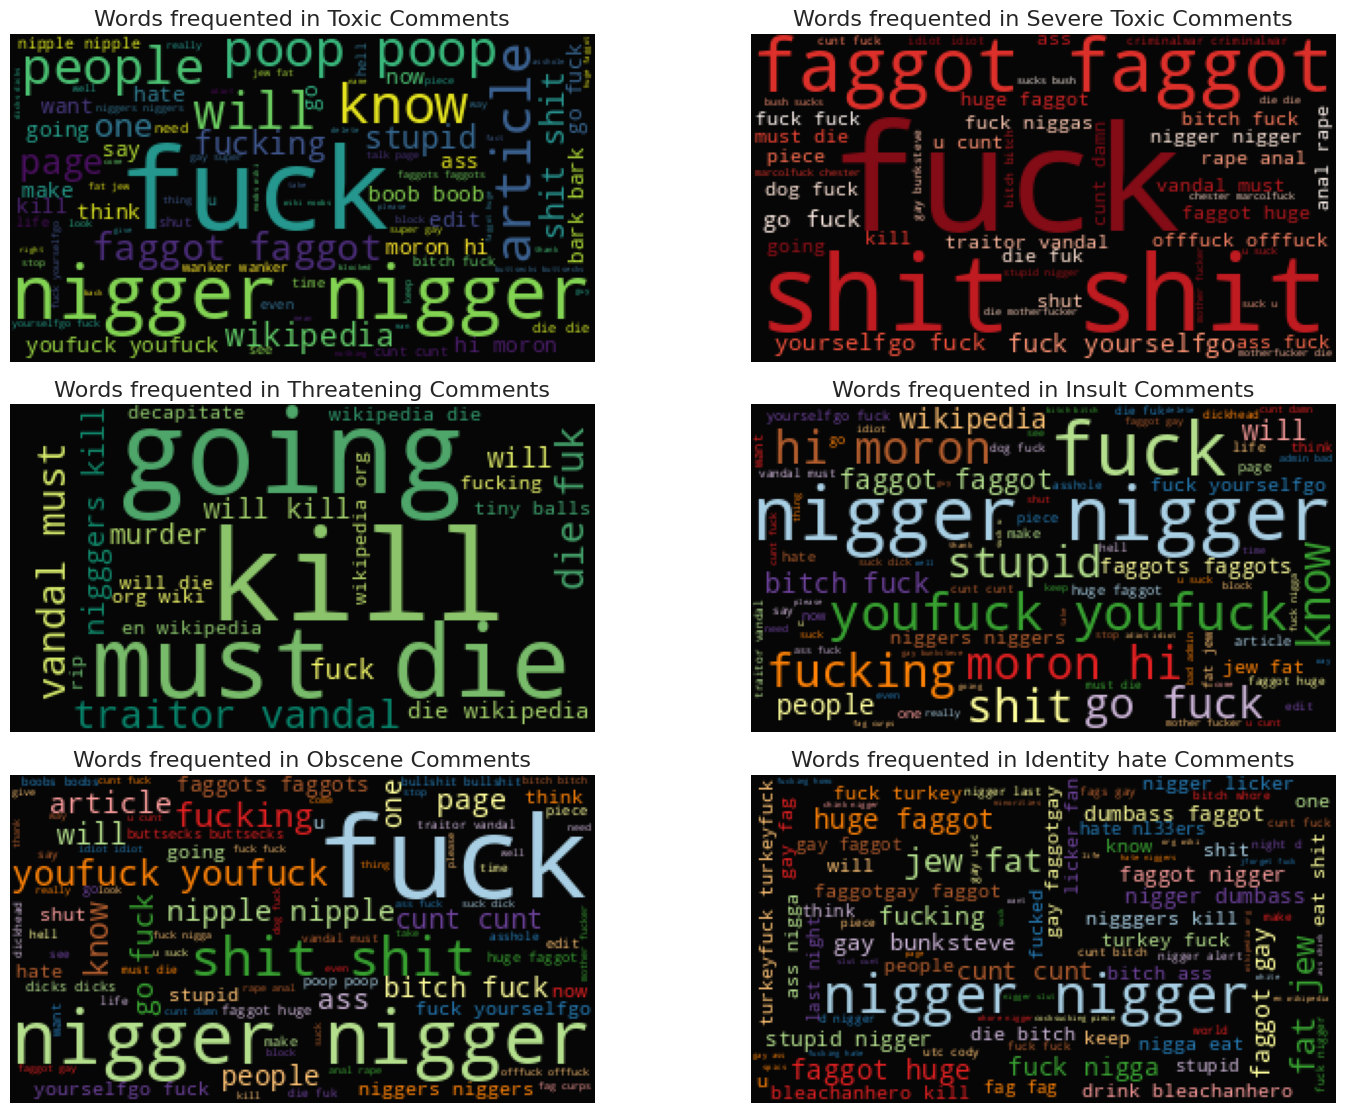

In [ ]:
# @title Most Frequent Words in Each Toxic Class
print("All we can do is aplogize but we do need to examine these for the sake of accuracy")
print("""\
⡴⠒⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣼⠉⠳⡆⠀
⣇⠰⠉⢙⡄⠀⠀⣴⠖⢦⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⣆⠁⠙⡆
⠘⡇⢠⠞⠉⠙⣾⠃⢀⡼⠀⠀⠀⠀⠀⠀⠀⢀⣼⡀⠄⢷⣄⣀⠀⠀⠀⠀⠀⠀⠀⠰⠒⠲⡄⠀⣏⣆⣀⡍
⠀⢠⡏⠀⡤⠒⠃⠀⡜⠀⠀⠀⠀⠀⢀⣴⠾⠛⡁⠀⠀⢀⣈⡉⠙⠳⣤⡀⠀⠀⠀⠘⣆⠀⣇⡼⢋⠀⠀⢱
⠀⠘⣇⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⡴⢋⡣⠊⡩⠋⠀⠀⠀⠣⡉⠲⣄⠀⠙⢆⠀⠀⠀⣸⠀⢉⠀⢀⠿⠀⢸
⠀⠀⠸⡄⠀⠈⢳⣄⡇⠀⠀⢀⡞⠀⠈⠀⢀⣴⣾⣿⣿⣿⣿⣦⡀⠀⠀⠀⠈⢧⠀⠀⢳⣰⠁⠀⠀⠀⣠⠃
⠀⠀⠀⠘⢄⣀⣸⠃⠀⠀⠀⡸⠀⠀⠀⢠⣿⣿⣿⣿⣿⣿⣿⣿⣿⣆⠀⠀⠀⠈⣇⠀⠀⠙⢄⣀⠤⠚⠁⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⢠⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡄⠀⠀⠀⢹⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡀⠀⠀⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡀⠀⠀⢘⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⢰⣿⣿⣿⡿⠛⠁⠀⠉⠛⢿⣿⣿⣿⣧⠀⠀⣼⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⡀⣸⣿⣿⠟⠀⠀⠀⠀⠀⠀⠀⢻⣿⣿⣿⡀⢀⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⡇⠹⠿⠋⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⡿⠁⡏⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠻⣤⣞⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢢⣀⣠⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠲⢤⣀⣀⠀⢀⣀⣀⠤⠒⠉⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀""")
print("This is Frank, Frank does not appreciate how nasty people are online!")

plt.figure(figsize=(15, 15))

# Wordcloud for obscene comments
plt.subplot(421)
subset = train_data.query("toxic == 1")
text = subset.comment_text.values
wc = WordCloud(background_color="black", max_words=2000, mask=clean_mask, stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Toxic Comments", fontsize=16)
plt.imshow(wc.recolor(colormap='viridis', random_state=17), alpha=0.98)

# Severely toxic comments
plt.subplot(422)
subset = train_data[train_data.severe_toxic == 1]
text = subset.comment_text.values
wc = WordCloud(background_color="black", max_words=2000, mask=clean_mask, stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Severe Toxic Comments", fontsize=16)
plt.imshow(wc.recolor(colormap='Reds', random_state=244), alpha=0.98)

# Threat comments
plt.subplot(423)
subset = train_data[train_data.threat == 1]
text = subset.comment_text.values
wc = WordCloud(background_color="black", max_words=2000, mask=clean_mask, stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Threatening Comments", fontsize=16)
plt.imshow(wc.recolor(colormap='summer', random_state=2534), alpha=0.98)

# Insult comments
plt.subplot(424)
subset = train_data[train_data.insult == 1]
text = subset.comment_text.values
wc = WordCloud(background_color="black", max_words=2000, mask=clean_mask, stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Insult Comments", fontsize=16)
plt.imshow(wc.recolor(colormap='Paired_r', random_state=244), alpha=0.98)

# Obscene comments
plt.subplot(425)
subset = train_data[train_data.obscene == 1]
text = subset.comment_text.values
wc = WordCloud(background_color="black", max_words=2000, mask=clean_mask, stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Obscene Comments", fontsize=16)
plt.imshow(wc.recolor(colormap='Paired_r', random_state=244), alpha=0.98)

# Identity Hate comments
plt.subplot(426)
subset = train_data[train_data.identity_hate== 1]
text = subset.comment_text.values
wc = WordCloud(background_color="black", max_words=2000, mask=clean_mask, stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Identity hate Comments", fontsize=16)
plt.imshow(wc.recolor(colormap='Paired_r', random_state=244), alpha=0.98)

plt.tight_layout()  # Adjust subplot parameters to give specified padding
plt.show()

Sorry about that, but I think that's enough data analyzing for my eyes to bear, let's move onto baselining and model building

# **Building First Simple Baseline**

The simplest baseline we can make it by taking the mean, which is pretty much equivelant to classifiying the input tweets as non-toxic, which should actually yield a tough bar to beat since most tweets are not toxic.

In [ ]:
# Calculate the mean/average of the target variable
mean_label = Y_train.mean()

# Create a list of predictions with the same length as the validation set,
# containing 1 if the mean is greater than or equal to 0.5, otherwise 0
baseline_predictions = [1 if mean_label >= 0.5 else 0] * len(X_val_padded)

# Calculate accuracy by comparing the baseline predictions with the actual labels
baseline_accuracy = accuracy_score(Y_val, baseline_predictions)
print("Baseline Accuracy (Predicting Mean):", baseline_accuracy)

Baseline Accuracy (Predicting Mean): 0.8985377582687952


This makes sense since we noticed, upon exploring the data, that majority of the tweets weren't toxic. However, let's explore the simple mean baselines for each degree of toxicity. This should give us the same accuracy because we are just flat out predicting that each tweet won't be toxic. Let's now look into how this performs for all levels of toxicity.

In [ ]:
for label in toxicity_labels:
  # Calculate the mean/average of the target variable
  mean_label = train_data[label].mean()

  # Create a list of predictions with the same length as the validation set,
  # containing 1 if the mean is greater than or equal to 0.5, otherwise 0
  baseline_predictions = [1 if mean_label >= 0.5 else 0] * len(X_val_padded)

  # Calculate accuracy by comparing the baseline predictions with the actual labels
  baseline_accuracy = accuracy_score(val_data[label], baseline_predictions)
  print("Baseline Accuracy (Predicting Mean) for", label, "tweets :", baseline_accuracy)

Baseline Accuracy (Predicting Mean) for toxic tweets : 0.9036542063913663
Baseline Accuracy (Predicting Mean) for severe_toxic tweets : 0.990913411804177
Baseline Accuracy (Predicting Mean) for obscene tweets : 0.9439706992479101
Baseline Accuracy (Predicting Mean) for threat tweets : 0.9965331171191322
Baseline Accuracy (Predicting Mean) for insult tweets : 0.9481085917186233
Baseline Accuracy (Predicting Mean) for identity_hate tweets : 0.9903262784130623
Baseline Accuracy (Predicting Mean) for negative_comment tweets : 0.8985377582687952


That makes for interesting reading as degree of accuracy, while still high, is varied. But, that's mainly due to the fact of the obscurity of some of the categories of toxicity.

Okay, we can reduce the vocab and then attempt to build some models.

In [ ]:
def limit_vocab(sequences, max_token_id, oov_id=2):
  """Replace token ids greater than or equal to max_token_id with the oov_id."""

  reduced_sequences = np.copy(sequences)
  reduced_sequences[reduced_sequences >= max_token_id] = oov_id
  return reduced_sequences

# Reduce vocabulary to 1000 tokens.
X_train_reduced = limit_vocab(X_train_padded, max_token_id=1000)
print(X_train_reduced[0])

# Decode to see what this looks like in tokens. Note the '#' for OOVs.
print(decode(X_train_reduced[0]))

[  6 182  49   2 400   9   7  60 266   5 315  38   6  34  25  65   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
you might like to consider that i don't give a shit what you do or think # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# **Experiment 3**

**Please note,** because the 3rd model is very demanding on the RAM specs, we need to place it before the previous 2 models so that the RAM isn't completely consumed causing the session to crash. This means that in the natural flow of things, you would first look at model 1, model 2, and then model 3, this is the order in which we coded them, but we had to put this beast upfront so that everything actually runs without crashing 😎.

## **Setup**

Let's use this space to try and build a model for multiclassification, that is, classifiying tweets into one of the many levels of toxicity!

We probably need to work backwards a little bit here and prepare the comments afresh, this time using the API and vectorizers as opposed to coding everything out (tokenization) for ourselves. This vectorizer is very nifty as it also standardizes the input as all punctuation and miscellaneous tokens are stripped and all sentences padded!

In [ ]:
#Define the size of our vocab
maximum_features = 20000

vectorizer = TextVectorization(max_tokens=maximum_features,
                               output_sequence_length=1800, output_mode='int')

vectorizer.adapt(X_stretch.values)
vectorized_text = vectorizer(X_stretch.values)
vectorized_text

<tf.Tensor: shape=(223549, 1800), dtype=int64, numpy=
array([[  643,    77,     2, ...,     0,     0,     0],
       [    1,    54,  2730, ...,     0,     0,     0],
       [  449,   425,    70, ...,     0,     0,     0],
       ...,
       [ 2038,    16,     7, ...,     0,     0,     0],
       [ 6908,  7440,     9, ...,     0,     0,     0],
       [15110,     1,  4273, ...,     0,     0,     0]])>

Let's quickly check that this vectorizer works!

In [ ]:
vectorizer("Let's classify some tweets!")

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([ 613, 7402,   62, ...,    0,    0,    0])>

After playing around with numbers, it seems that 1800 works nicely for the X values and 6 for the Y batch (different levels of toxicity).

We can now create a tensor flow data pipeline, which will greatly help since we're working with a large dataset here.

In [ ]:
#Standard Data Pipline generation
data_set = tf.data.Dataset.from_tensor_slices((vectorized_text, Y_stretch))
data_set = data_set.cache()
data_set = data_set.shuffle(160000)
data_set = data_set.batch(16)
data_set = data_set.prefetch(8)

#Split that data
stretch_train = data_set.take(int(len(data_set)*.7))
stretch_val = data_set.skip(int(len(data_set)*.7)).take(int(len(data_set)*.2))
stretch_test = data_set.skip(int(len(data_set)*.9)).take(int(len(data_set)*.1))

## **Building New Deep Learning Model**

Now we can begin to build the model for this experiment. We can hopefully learn the right sentiments for words and build negative/positive associations.
This allows us to build a model with serveral layers, and we get to try out these technologies for the first time for ourselves:

*   LSTM
*   Tanh activation
*   Bidirectional layers

We get to try out Tanh activation for the LSTM because the activation function required for the GPU acceleration for a LSTM layer is Tanh. For more information <a href='https://stackoverflow.com/questions/40761185/what-is-the-intuition-of-using-tanh-in-lstm'>click here<a>

Bidirectional layers also allow for both backward and forwarding (wrapping) of data between layers, super interesting! This is also very helpful for our dataset because, for example 'You are a great liar" would first pick up on the positive sentiment of "great" but then works backwards after spotting the toke for "liar".

In [ ]:
stretch_model = Sequential()
stretch_model.add(Embedding(maximum_features+1, 32)) # Embedding layers + 1 for unkown words
stretch_model.add(Bidirectional(LSTM(32, activation='tanh')))
stretch_model.add(Dense(128, activation='relu')) #Intermediary connected dense layers
stretch_model.add(Dense(256, activation='relu'))
stretch_model.add(Dense(128, activation='relu'))
stretch_model.add(Dense(6, activation='sigmoid')) #Final layer

## **Compiling and Analyzing**

Awesome, let's compile and analyze this model. Eventhough we are effectively doing multiclassification, we are, more practically speaking, running 6 binary classifiers concurrently, hence the use of binary cross entropy instead of something like categorical cross entropy for the loss method.

In [ ]:
stretch_model.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics=['accuracy'])
stretch_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          640032    
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

Unfortunately, here is where we will hit a hardware roadblock due to the limited specs of the Google Codelab GPU. It will take about 25 minutes for this model to be fully trained in one epoch. Please do bear with us and just let all of this run once as there's nothing else we can do and we want to build a good model : ) thank you for your patience!

We want an optimal model here, and we believe it's worth the wait to see what we can achieve with just the one epoch at least. **Again, you need T4 with GPUs  or greater specs to run this**.

RIP Google's RAM GPUs (•ᴗ•,, )

In [ ]:
# Train the model
stretch_hist = stretch_model.fit(
    stretch_train,
    epochs=1,
    validation_data=stretch_val,
)

9780/9780 [==============================] - 1109s 113ms/step - loss: 0.0643 - accuracy: 0.9871 - val_loss: 0.0537 - val_accuracy: 0.9953


## **Predicting and Texting**

Great, we appreciate your patience. Now, let's try running the model on an obviously negative tweet.

In [ ]:
#Please excuse my language!
toxic_input = vectorizer("You really suck at this game loser!")
batch = stretch_test.as_numpy_iterator().next()
pred = stretch_model.predict(np.expand_dims(toxic_input,0))

1/1 [==============================] - 3s 3s/step


In [ ]:
print(pred)
print(original_data.columns[2:])

[[0.8625889  0.03584215 0.6022735  0.01435213 0.50371295 0.06672025]]
Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')


Great! It looks like the model is classifiying it as toxic and obscene/threat depending on your run.

## **Evaluation**

We can now investigate the precision, accuracy, and recall.

In [ ]:
precision = Precision()
recall = Recall()
accuracy = CategoricalAccuracy()

In [ ]:
#unpacking each batch and measuring the prediction made
print("This should take ~5 minutes.")

true_labels = []
predicted_labels = []

for batch in stretch_test.as_numpy_iterator():
  x_true, y_true = batch
  y_pred = stretch_model.predict(x_true)
  y_true = y_true.flatten()
  y_pred = y_pred.flatten()
  y_pred = (y_pred >= 0.5) * 1

  true_labels.extend(y_true)
  predicted_labels.extend(y_pred)

  precision.update_state(y_true, y_pred)
  recall.update_state(y_true, y_pred)
  accuracy.update_state(y_true, y_pred)

This should take ~5 minutes.
1/1 [==============================] - 0s 52ms/step


In [ ]:
print(f'Precision: {precision.result().numpy()}, Recall:{recall.result().numpy()}, Accuracy:{accuracy.result().numpy()}')

Precision: 0.7920457720756531, Recall:0.6237461566925049, Accuracy:0.6599856615066528


That's a good start for a 1 epoch train, not the best model but with the limited RAM this is optimal. We have clearly beaten our very high baseline by ~0.3 lower loss, and more specifically we have achieved a precision of approximately 0.84 on must runs. This indicates that about 80-84% of the model's positive predictions are correct. Now again the recall and accuracy needs improving but with our constraints, they'll do.
You can try training for more epochs if you have the time and RAM and those numbers should go up

## **Testing and Building An App**

This is something we're really excited to do! We want to build an actual UI that let's you pass in a tweet and will return a toxic (or not) classification prediction. After some online research we found that <a href='https://www.gradio.app/'> Gradio </a> would be a nice tool to use.

In [ ]:
stretch_model.save('toxicity_predictor.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [ ]:
def tweet_scorer(tweet):
  vectorized_tweet = vectorizer([tweet])
  predictions = stretch_model.predict(vectorized_tweet)

  response = ''
  for i, j in enumerate(original_data.columns[2:]):
    response += '{}: {}\n'.format(j, predictions[0][i]>0.5)
  return response

Build the UI and Launch! Please play around with it, and press the end cell button to stop and allow the rest of the lab to run. Unfortunately, to trigger the other classes of toxicity, you have to enter in some real nasty tweets (╥_╥).

In [ ]:
UI = gr.Interface(
    fn=tweet_scorer,
    inputs="text",
    outputs='text'
)

UI.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://dc6dcc2d9fc2da1779.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 51ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://dc6dcc2d9fc2da1779.gradio.live


# **Experiment 1 - Basic Embeddings Model**

We will attempt to build a more simple embeddings model and see how that performs

## **Defining Model**

In [ ]:
def build_embeddings_model(vocab_size=1000, sequence_length=20,embedding_dim=1):
  """Build a tf.keras model using embeddings."""

  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.keras.utils.set_random_seed(0)

  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      input_length=sequence_length))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy',optimizer='adamax',metrics=['accuracy'])
  return model

## **Training Model**



Epoch 1/8
2236/2236 [==============================] - 54s 24ms/step - loss: 0.3170 - accuracy: 0.8999 - val_loss: 0.2903 - val_accuracy: 0.8989
Epoch 2/8
2236/2236 [==============================] - 16s 7ms/step - loss: 0.2646 - accuracy: 0.9017 - val_loss: 0.2470 - val_accuracy: 0.9047
Epoch 3/8
2236/2236 [==============================] - 14s 6ms/step - loss: 0.2325 - accuracy: 0.9109 - val_loss: 0.2251 - val_accuracy: 0.9169
Epoch 4/8
2236/2236 [==============================] - 12s 5ms/step - loss: 0.2147 - accuracy: 0.9196 - val_loss: 0.2105 - val_accuracy: 0.9221
Epoch 5/8
2236/2236 [==============================] - 10s 5ms/step - loss: 0.2029 - accuracy: 0.9251 - val_loss: 0.2004 - val_accuracy: 0.9266
Epoch 6/8
2236/2236 [==============================] - 10s 4ms/step - loss: 0.1942 - accuracy: 0.9290 - val_loss: 0.1934 - val_accuracy: 0.9287
Epoch 7/8
2236/2236 [==============================] - 11s 5ms/step - loss: 0.1877 - accuracy: 0.9314 - val_loss: 0.1881 - val_accuracy

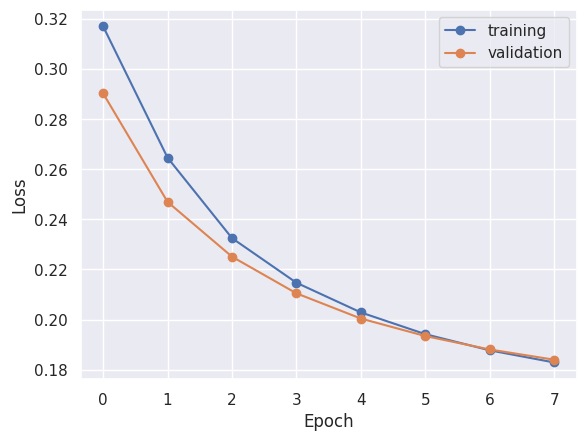

In [ ]:
X_train_padded = padding_data(X_train, maximum_len=300)
X_train_reduced = limit_vocab(X_train_padded, max_token_id=1000)

X_val_padded = padding_data(X_val, maximum_len=300)
X_val_reduced = limit_vocab(X_val_padded, max_token_id=1000)


model = build_embeddings_model(vocab_size=1000, sequence_length=300, embedding_dim=1)

history = model.fit(
  x = X_train_reduced,  # our sparse padded training data
  y = Y_train,          # corresponding binary labels
  epochs=8,             # number of passes through the training data
  batch_size=64,    # mini-batch size
  validation_data = (X_val_reduced, Y_val),
  verbose=1             # display some progress output during training
  )

history = pd.DataFrame(history.history)
plot_history(history)

Very promising training history graph, let's evaluate this model

## **Evaluate Model**

In [ ]:
X_test_padded = padding_data(X_test, maximum_len=300)
X_test_reduced = limit_vocab(X_test_padded, max_token_id=1000)
model.evaluate(X_test_reduced, Y_test)

1398/1398 [==============================] - 3s 2ms/step - loss: 0.1820 - accuracy: 0.9336


[0.18195967376232147, 0.9336404800415039]

Interesting, before we really comment, let's build all three models.

# **Experiment 2 - Feed Forward Neural Network**

Next, let's try a FFN with Global average pooling with multiple dense layers.

## **Defining Model**

In [ ]:
def build_deep_embeddings_model(vocab_size, sequence_length, embedding_dim):
    """Build a tf.keras model using embeddings."""

    tf.keras.backend.clear_session()
    tf.keras.utils.set_random_seed(0)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=sequence_length)
    )

    model.add(tf.keras.layers.GlobalAveragePooling1D())

    model.add(tf.keras.layers.Dense(units=128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(units=64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(units=32, activation='relu'))

    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01)))  # Add L2 regularization
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

## **Train Model**

Epoch 1/5
559/559 [==============================] - 70s 121ms/step - loss: 0.3537 - accuracy: 0.8991 - val_loss: 0.3089 - val_accuracy: 0.8985
Epoch 2/5
559/559 [==============================] - 33s 58ms/step - loss: 0.2668 - accuracy: 0.9042 - val_loss: 0.2192 - val_accuracy: 0.9159
Epoch 3/5
559/559 [==============================] - 23s 42ms/step - loss: 0.2108 - accuracy: 0.9198 - val_loss: 0.2042 - val_accuracy: 0.9268
Epoch 4/5
559/559 [==============================] - 14s 26ms/step - loss: 0.1884 - accuracy: 0.9294 - val_loss: 0.1803 - val_accuracy: 0.9344
Epoch 5/5
559/559 [==============================] - 12s 22ms/step - loss: 0.1727 - accuracy: 0.9369 - val_loss: 0.1718 - val_accuracy: 0.9375


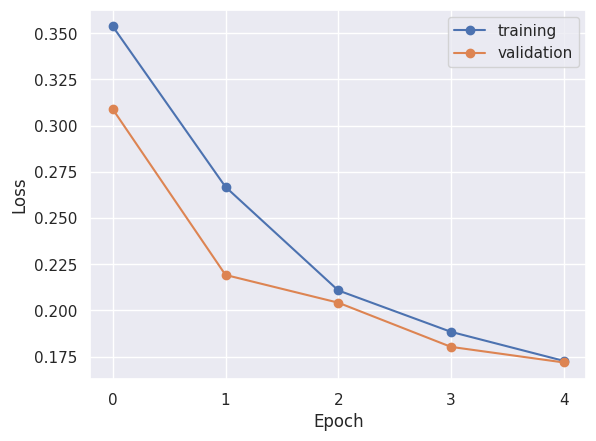

In [ ]:
X_train_padded = padding_data(X_train, maximum_len=1000)
X_train_reduced = limit_vocab(X_train_padded, max_token_id=20000)

X_val_padded = padding_data(X_val, maximum_len=1000)
X_val_reduced = limit_vocab(X_val_padded, max_token_id=20000)

model = build_deep_embeddings_model(vocab_size=20000,
                               sequence_length=1000,
                               embedding_dim=1)

history = model.fit(
  x = X_train_reduced,
  y = Y_train,
  epochs=5,
  batch_size=256,
  validation_data = (X_val_reduced, Y_val),
  verbose=1,
  )

history = pd.DataFrame(history.history)
plot_history(history)

Training history looks great, let's evaluate this model too!

## **Evaluate Model**


In [ ]:
X_test_padded = padding_data(X_test, maximum_len=1000)
X_test_reduced = limit_vocab(X_test_padded, max_token_id=20000)
model.evaluate(X_test_reduced, Y_test)

1398/1398 [==============================] - 4s 3ms/step - loss: 0.1709 - accuracy: 0.9376


[0.17092503607273102, 0.9375545382499695]

Even better!

# **Error Analysis**

For purpose of analysis we will focus on Expriment 3.

Accuracy of the Deep Learning Model:
1. Training Data: 0.9861
2. Validation Data: 0.9955
3. Testing Data: 0.6321

Experiment 3 is essentialy 6 binary classifiers working in tandem to determine wether or not a comment should be classified as either one of the classes. This allows a comment to be assigned to multiple classes for instance, a comment can be both "toxic" and "obscene" this way our model is more efficiently able to classify each comment.

Let us analyses the performance of the models by binary classifiers:


In [ ]:
true = np.array(true_labels).reshape(-1, 6)
predicted = np.array(predicted_labels).reshape(-1, 6)

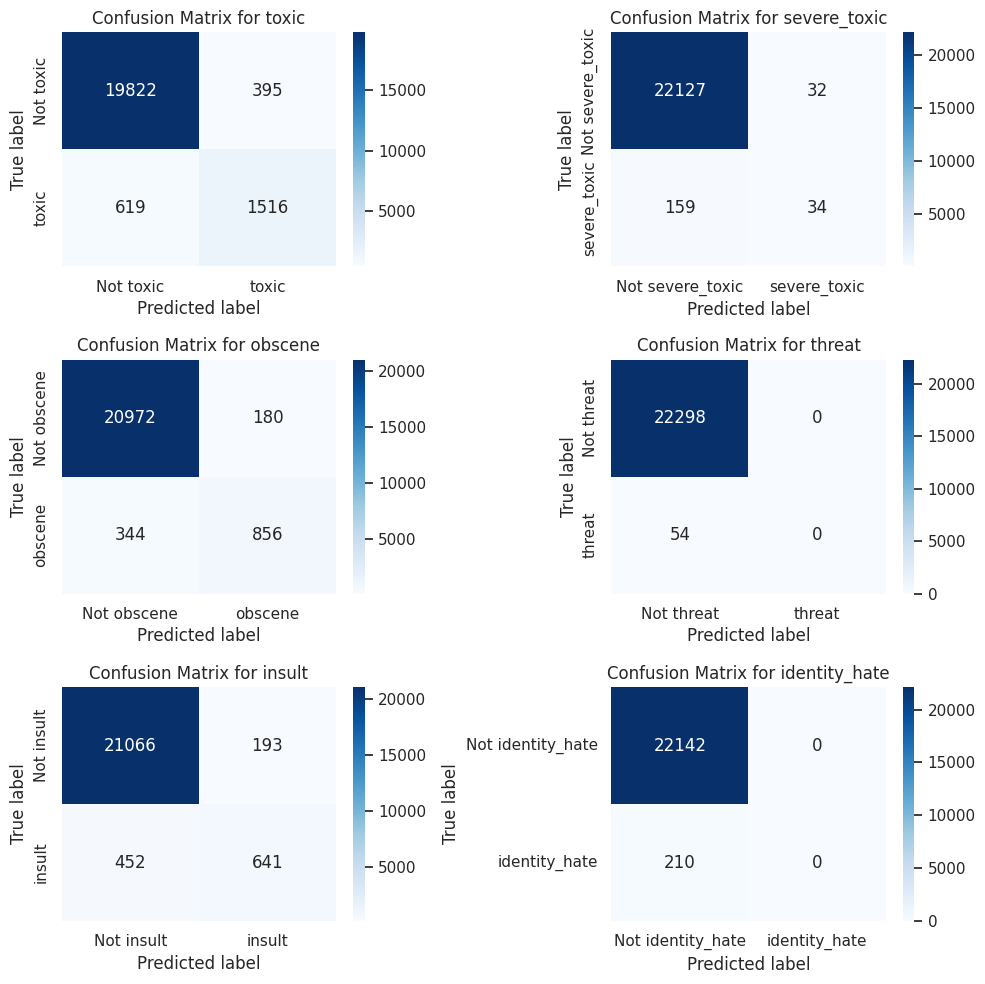

In [ ]:
# @title Plotting Confusion Matrices
label_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

for i, ax in enumerate(axes.flatten()):
    axis = [f"Not {label_names[i]}", f'{label_names[i]}']
    cm = tf.math.confusion_matrix(true[:, i], predicted[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=axis, yticklabels=axis, ax=ax)
    ax.set_title(f'Confusion Matrix for {label_names[i]}')
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')

plt.tight_layout()
plt.show()

From the confusion matrix above it can be determined that this model(combination of classifiers) perfomed very average on the test data.

The model struggles to determine if a comment is a "threat", "identity hate" or "severe toxic". This can be due to the fact that the training data did not contain enough examples for the model to assign enough weigth to the words and phrases associated with these categories.

The model perfoms averagely on determining if a comment is "toxic", "obscene" or an "insult". However it still miss-classifies about 40-50 percent of comments as which are supposed to be in theses classes.

Overall, it seems as if the model perfroms well on the training and validation data but performs worse than anticipated on the test data. This can imply that there may be some form of data leakage between the train and validation data.


# **Conclusion**

## Summary
In this Colab we explored how Models 1 and 2 can be utilised to classify comments as "normal" or "negative" while we explored how Model 3 can be used to further classify negative comments into more categories such as toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate.


**Model 1:** our basic embedding model performed suprisingly well on detecting wether a comment is negative or not, the use of the "adamax" optimizer here instead "adam" proved to be quite useful in reducing some of the overiffiting. This lead to a well perfoming model with an accuracy of 0.9336 on the test data, suprisingly good for such a simple model.


**Model 2:** which is a feedforward neural network also performed quite well on classifying the comment as negative or not. This model was a bit more complex than the first as it had a lot more layers and parameters. It was more challenging to fine tune this model however in the end it came our performing quite well: 0.93744


**Model 3:** The deep learning model was monster to train even using the TP4 runtime instead of the standard runtime this thing took 20+ minutes to train. We often hit the limits of the standard colab runtime and multiple times our accounts had cooldown period for the resources; it tooks hours.
It performed quite promising on the train and validation data but was quite uderwhelming on the test data with an accuracy of only: 0.6198


## Observation:

Sometimes less is more (dependent on the use case), with our simplest embedding model, it performed quite well it pretty much matched the perfomance of the FFNN which was quite impressive.

Data does not always come in a format that is easily ready to train models or make userful inferences from, in this instance feature inference is neccesary to gather useful inferences from the data to then train our models.


## Learning outcomes:

Finetuning, especially hyperparameter tuning is a tedious process that requires much trial an error however after much exprimentation one kind of gets the hang of which parameters to tweak to get the desired outcome.

Training models are resource intensive : ( Many times during this proces we maxed out the base computing power for Google Colab and as a result we had to wait several hours for us to be granted resources again or use other means ; ).
